## Merlin6 adaptations

On PSI's Merlin6 cluster, this notebook should be run from the GPU queue. Request extra memory when starting (e.g. 50GB). Then, go to Kernel » Change Kernel » Python \[conda env:cryocare\].

The following changes have been made to this notebook for Merlin6 compatibility:

- Data is stored in ./data rather than /data

# Training Data Generation

In this step we will extract the training/validation data from the even/odd tomograms. 

In [1]:
from generate_train_data import *

import mrcfile
from os.path import join, isdir
from os import makedirs

from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Load the two tomograms
even = mrcfile.open('data/Tomo110/frames/even/Tomo110_even.rec').data
odd = mrcfile.open('data/Tomo110/frames/odd/Tomo110_odd.rec').data

In [3]:
# Here we compute the mean and standard deviation which is needed to
# normalize the inputs for the network.
mean, std = compute_mean_std(np.stack((even, odd)))
print(mean, std)

0.087762676 2.0187595


In [4]:
# Create the train_data directory
if not isdir('data/Tomo110/train_data'):
    makedirs('data/Tomo110/train_data')
# We save mean and standard deviation since it is needed during prediction.
np.savez('data/Tomo110/train_data/mean_std.npz', mean=mean, std=std)

## Masking

In some cases you want to sample training/validation data not from the whole tomogram in that case you can create a mask from which the samples will be drawn. 

For this example we want to sample from the whole tomogram evenly. So we create a mask with all foreground (1).

In [5]:
mask = np.ones(even.shape, dtype=np.int8)

## Sample Coordinates

With our mask we will now sample coordinates for the train and validation volumes. 

The method `sample_coordinates` will return two lists with coordinates of volumes. The train and validation volumes will not overlap.

In [6]:
train_coords, val_coords = sample_coordinates(mask, num_train_vols=1200, num_val_vols=120, vol_dims=(64,64,64))

## Extract Volumes

In [7]:
# Now we use the sampled coordinates to extract the train- and validation-volumes.
X, Y, X_val, Y_val = extract_volumes(even, odd, train_coords, val_coords, mean, std)

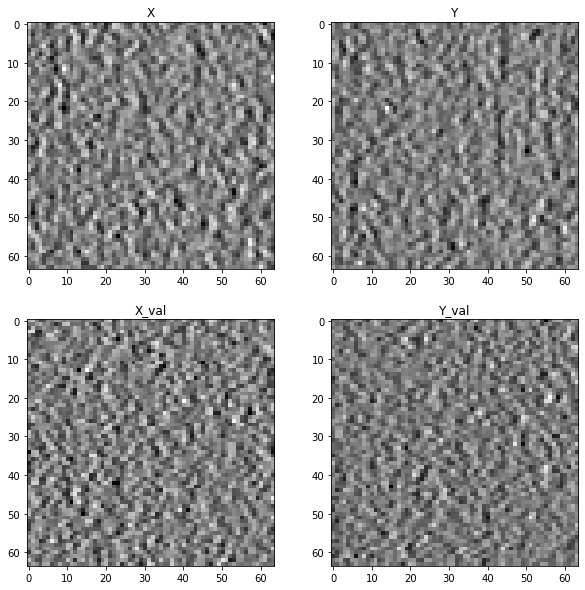

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(X[0,48,:,:,0], cmap='gray')
plt.title('X');
plt.subplot(2,2,2)
plt.imshow(Y[0,48,:,:,0], cmap='gray')
plt.title('Y');
plt.subplot(2,2,3)
plt.imshow(X_val[0,48,:,:,0], cmap='gray')
plt.title('X_val');
plt.subplot(2,2,4)
plt.imshow(Y_val[0,48,:,:,0], cmap='gray')
plt.title('Y_val');

## Save Train-/Validation-Data

In [9]:
np.savez('data/Tomo110/train_data/train_data.npz', X=X, Y=Y, X_val=X_val, Y_val=Y_val)